## Installing **transformers** for further usage (please do not alter the version for stable usage of model)

In [1]:
import torch
from modelscope import AutoTokenizer, AutoModelForCausalLM

model_id = "google/gemma-2-2b-it"
dtype = torch.float16

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=dtype,
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Q1: Chat template Comparison

### Evaluation Model: https://huggingface.co/cross-encoder/ms-marco-MiniLM-L-6-v2


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

SCORING_MODEL = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-MiniLM-L-6-v2')
SCORING_TOKENIZER = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-MiniLM-L-6-v2')


def calculate_coherence(question, answer, scoring_model=SCORING_MODEL, tokenizer=SCORING_TOKENIZER):
  features = tokenizer([question], [answer], padding=True, truncation=True, return_tensors="pt")
  scoring_model.eval()
  with torch.no_grad():
      scores = scoring_model(**features).logits.squeeze().item()
  return scores

### Observe whether the chat template affects the model's output results.

In [3]:
def generate_text_from_prompt(prompt, tokenizer, model):
  """
  generate the output from the prompt.
  param:
    prompt (str): the prompt inputted to the model
    tokenizer   : the tokenizer that is used to encode / decode the input / output
    model       : the model that is used to generate the output

  return:
    the response of the model
  """
  print("========== Prompt inputted to the model ==========\n", prompt)

  # Tokenize the prompt
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

  ######################## TODO (Q1.1 ~ 1.4) ########################
  ### You can refer to https://huggingface.co/google/gemma-2-2b-it for basic usage
  ### Make sure to use 'do_sample=False' to get a deterministic response
  ### Otherwise the coherence score may be different from the sample answer

  # Generate response
  output_ids = model.generate(
        input_ids=input_ids,
        do_sample=False,      # 禁用采样 → 确保确定性输出
        max_new_tokens=512,   # 限制生成长度（避免生成过长）
        pad_token_id=tokenizer.eos_token_id  # 避免部分模型出错
    )
  ###################################################################
  if output_ids is not None and len(output_ids) > 0:
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)
  else:
    return "Empty Response"

In [4]:
# With chat template
question = "Please tell me about the key differences between supervised learning and unsupervised learning. Answer in 200 words."
chat = [
    {"role": "user", "content": question},
]
prompt_with_template = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
response_with_template = generate_text_from_prompt(prompt_with_template, tokenizer, model)

# extract the real output from the model
response_with_template = response_with_template.split('model\n')[-1].strip('\n').strip()

print("========== Output ==========\n", response_with_template)
score = calculate_coherence(question, response_with_template)
print(f"========== Coherence Score : {score:.4f}  ==========")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


========== Prompt inputted to the model ==========
 <bos><start_of_turn>user
Please tell me about the key differences between supervised learning and unsupervised learning. Answer in 200 words.<end_of_turn>
<start_of_turn>model

========== Output ==========
 Supervised and unsupervised learning are two fundamental types of machine learning. 

**Supervised learning** involves training a model on labeled data, where each input has a corresponding output. The model learns to map inputs to outputs, making predictions on new, unseen data. Think of it like teaching a child with labeled examples: you show them pictures of cats and dogs, and they learn to distinguish between them. 

**Unsupervised learning**, on the other hand, uses unlabeled data. The model learns patterns and structures within the data without explicit guidance. It's like letting a child explore a room full of toys and discover patterns on their own. Examples include clustering similar items or finding hidden relationships i

In [18]:
# Without chat template (directly using plain text)
response_without_template = generate_text_from_prompt(question, tokenizer, model)

# extract the real output from the model
response_without_template = response_without_template.split(question.split(' ')[-1])[-1].strip('\n').strip()
print("========== Output ==========\n", response_without_template)
score = calculate_coherence(question, response_without_template)
print(f"========== Coherence Score : {score:.4f}  ==========")

========== Prompt inputted to the model ==========
 Please tell me about the key differences between supervised learning and unsupervised learning. Answer in 200 words.
========== Output ==========
 **Supervised Learning:**

* **Labeled data:** Uses data with known outputs (labels) to train models.
* **Goal:** Predict outputs for new, unseen data.
* **Examples:** Image classification, spam detection, predicting house prices.

**Unsupervised Learning:**

* **Unlabeled data:** Uses data without known outputs to discover patterns.
* **Goal:** Explore data, identify clusters, or reduce dimensionality.
* **Examples:** Customer segmentation, anomaly detection, dimensionality reduction.


In essence, supervised learning learns from labeled examples to make predictions, while unsupervised learning explores unlabeled data to uncover hidden structures and relationships.
========== Coherence Score : 4.1658  ==========


## Q2: Multi-turn conversations

Chatbot: Hello! How can I assist you today? (Type 'exit' to quit)
=== Prompt with chat template format inputted to the model on round 1 ===
<bos><start_of_turn>user
Name a color in a rainbow, please just answer in a word without any emoji.<end_of_turn>
<start_of_turn>model



/tmp/ipykernel_20992/4134493486.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_tokens, palette="coolwarm")


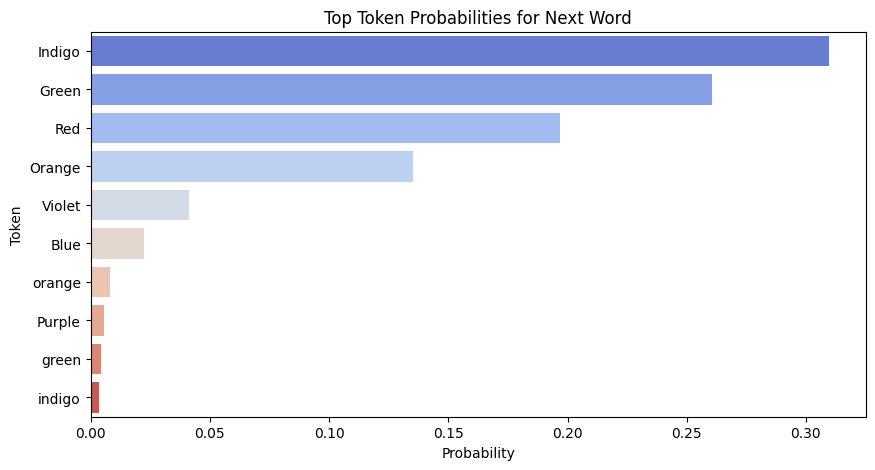

Chatbot: Indigo 

=== Prompt with chat template format inputted to the model on round 2 ===
<bos><start_of_turn>user
Name a color in a rainbow, please just answer in a word without any emoji.<end_of_turn>
<start_of_turn>model
Indigo<end_of_turn>
<start_of_turn>user
That’s great! Now, could you tell me another color that I can find in a rainbow?<end_of_turn>
<start_of_turn>model



/tmp/ipykernel_20992/4134493486.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_tokens, palette="coolwarm")


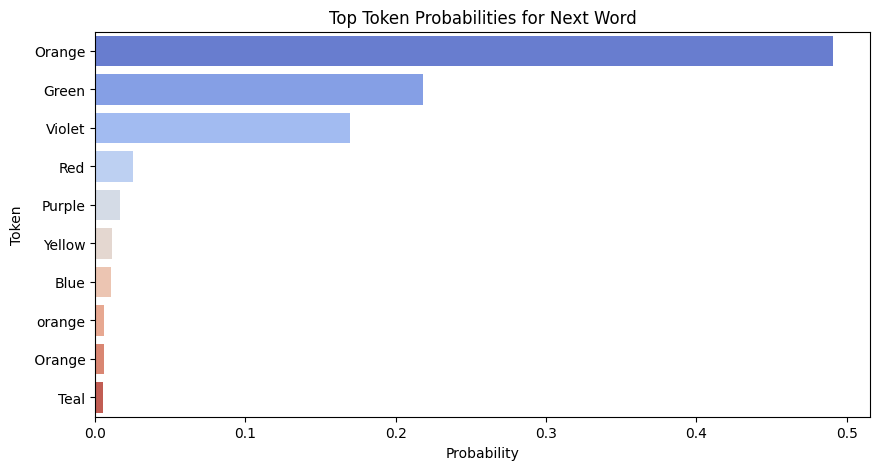

Chatbot: Orange 

=== Prompt with chat template format inputted to the model on round 3 ===
<bos><start_of_turn>user
Name a color in a rainbow, please just answer in a word without any emoji.<end_of_turn>
<start_of_turn>model
Indigo<end_of_turn>
<start_of_turn>user
That’s great! Now, could you tell me another color that I can find in a rainbow?<end_of_turn>
<start_of_turn>model
Orange<end_of_turn>
<start_of_turn>user
Could you continue and name yet another color from the rainbow?<end_of_turn>
<start_of_turn>model



/tmp/ipykernel_20992/4134493486.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_tokens, palette="coolwarm")


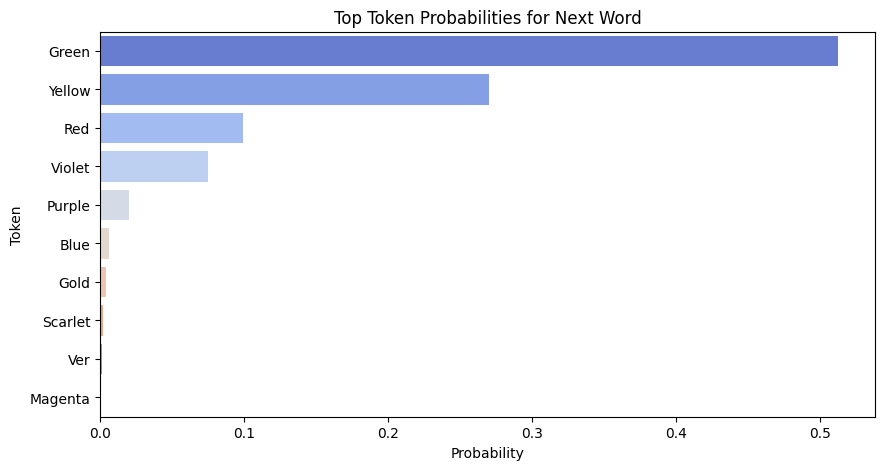

Chatbot: Green 



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
chat_history = []
round = 0
print("Chatbot: Hello! How can I assist you today? (Type 'exit' to quit)")

while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        print("Chatbot: Goodbye!")
        break

    round += 1
    chat_history.append({"role": "user", "content": user_input})
    chat_template_format_prompt = tokenizer.apply_chat_template(chat_history, tokenize=False, add_generation_prompt=True)
    ######################## (Q2.1 ~ 2.3) ########################
    # Observe the prompt with chat template format that was inputted to the model in the current round to answer Q2.1 ~ Q2.3.
    print(f"=== Prompt with chat template format inputted to the model on round {round} ===\n{chat_template_format_prompt}")
    print(f"===============================================")
    ###################################################################

    inputs = tokenizer(chat_template_format_prompt, return_tensors="pt").to("cuda")
    # Get logits instead of directly generating
    with torch.no_grad():
        outputs_p = model(**inputs)

    logits = outputs_p.logits  # Logits of the model (raw scores before softmax)
    last_token_logits = logits[:, -1, :]  # Take the logits of the last generated token

    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(last_token_logits, dim=-1)

    # Get top-k tokens (e.g., 10)
    top_k = 10
    top_probs, top_indices = torch.topk(probs, top_k)

    # Convert to numpy for plotting
    top_probs = top_probs.cpu().squeeze().numpy()
    top_indices = top_indices.cpu().squeeze().numpy()
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices]

    # Plot probability distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_probs, y=top_tokens, palette="coolwarm")
    plt.xlabel("Probability")
    plt.ylabel("Token")
    plt.title("Top Token Probabilities for Next Word")
    plt.show()

    # Generate response
    outputs = model.generate(**inputs, max_new_tokens=200, pad_token_id=tokenizer.eos_token_id, do_sample=False)
    response = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    print(f"Chatbot: {response}")
    chat_history.append({"role": "assistant", "content": response})

## Q3: Tokenization of Sentence

In [5]:
sentence = "I love taking a Machine Learning course by Professor Hung-yi Lee, What about you?" #@param {type:"string"}

######################## TODO (Q3.1 ~ 3.4) ########################
### You can refer to https://huggingface.co/learn/nlp-course/en/chapter2/4?fw=pt for basic tokenizer usage
### and https://huggingface.co/docs/transformers/en/main_classes/tokenizer for full tokenizer usage


# Encode the sentence into token IDs without adding special tokens
token_ids =tokenizer.encode(sentence, add_special_tokens=False)

# Convert the token IDs back to their corresponding tokens (words or subwords)
tokens =tokenizer.convert_ids_to_tokens(token_ids)
###################################################################

# Iterate through the tokens and their corresponding token IDs
for t, t_id in zip(tokens, token_ids):
    # Print the token and its index (ID)
    print(f"Token: {t}, token index: {t_id}")

Token: I, token index: 235285
Token: ▁love, token index: 2182
Token: ▁taking, token index: 4998
Token: ▁a, token index: 476
Token: ▁Machine, token index: 13403
Token: ▁Learning, token index: 14715
Token: ▁course, token index: 3205
Token: ▁by, token index: 731
Token: ▁Professor, token index: 11325
Token: ▁Hung, token index: 18809
Token: -, token index: 235290
Token: yi, token index: 12636
Token: ▁Lee, token index: 9201
Token: ,, token index: 235269
Token: ▁What, token index: 2439
Token: ▁about, token index: 1105
Token: ▁you, token index: 692
Token: ?, token index: 235336


## Q4: Auto-regressive generation

In [7]:
from tqdm import trange
from transformers import HybridCache

max_generation_tokens = 30

######################## TODO (Q4.3 ~ 4.6) ########################
# Modify the value of k and p accordingly

top_k = 2  # Set K for top-k sampling
top_p = 0.6  # Set P for nucleus sampling
###################################################################

# Input prompt
prompt = f"Generate a paraphrase of the sentence 'Professor Hung-yi Lee is one of the best teachers in the domain of machine learning'. Just response with one sentence."
input_ids = tokenizer(prompt, return_tensors="pt")

# Initialize KV Cache
kv_cache = HybridCache(config=model.config, max_batch_size=1, max_cache_len=max_generation_tokens, device="cuda", dtype=torch.float16)

next_token_id = input_ids.input_ids.to("cuda")
attention_mask = input_ids.attention_mask.to("cuda")
cache_position = torch.arange(attention_mask.shape[1], device="cuda")

generated_sentences_top_k = []
generated_sentences_top_p = []



# Define the generation parameters
generation_params = {
    "do_sample": True,  # Enable sampling
    "max_length": max_generation_tokens + len(input_ids.input_ids[0]),  # Total length including prompt
    "pad_token_id": tokenizer.pad_token_id,  # Ensure padding token is set
    "eos_token_id": tokenizer.eos_token_id,  # Ensure EOS token is set
    "bos_token_id": tokenizer.bos_token_id,  # Ensure BOS token is set
    "attention_mask": input_ids.attention_mask.to("cuda"),  # Move attention mask to GPU
    "use_cache": True,  # Enable caching
    "return_dict_in_generate": True,  # Return generation outputs
    "output_scores": False,  # Disable outputting scores
}


for method in ["top-k", "top-p"]:
    for _ in trange(20):
      if method == "top-k":
        # Generate text using the model with top_k
        generated_output = model.generate(
            input_ids=input_ids.input_ids.to("cuda"),
            top_k=top_k,
            **generation_params
        )
      elif method == "top-p":
        # Generate text using the model with top_p
        ######################## TODO (Q4.3 ~ 4.6) ########################
        # Generate output from the model based on the input_ids and specified generation parameters
        # You can refer to this documentation: https://huggingface.co/docs/transformers/en/main_classes/text_generation
        # Hint: You can check how we generate the text with top_k

        generated_output =model.generate(
    input_ids=input_ids.input_ids.to("cuda"),
    top_k=top_k,
    **generation_params
)
        ###################################################################
      else:
        raise NotImplementedError()
      # Decode the generated tokens
      generated_tokens = generated_output.sequences[0, len(input_ids.input_ids[0]):]
      decoded_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

      # Combine the prompt with the generated text
      sentence = decoded_text.replace(" ,", ",").replace(" 's", "'s").replace(" .", ".").strip()

      # Append the generated sentence to the appropriate list
      if method == "top-k":
          generated_sentences_top_k.append(sentence)
      else:
          generated_sentences_top_p.append(sentence)

# Print results
print("===== Top-K Sampling Output =====")
print()
for idx,sentence in enumerate(generated_sentences_top_k):
    print(f"{idx}. {sentence}")
print()
print("===== Top-P Sampling Output =====")
print()
for idx,sentence in enumerate(generated_sentences_top_p):
    print(f"{idx}. {sentence}")
print()

`HybridCache` is deprecated and will be removed in version v4.59 Use `StaticCache(...)` instead which will correctly infer the type of each layer.
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]

===== Top-K Sampling Output =====

0. He's highly regarded as a top-notch machine learning educator.
1. Professor Lee is highly regarded as a top-tier machine learning educator.
2. He is highly regarded as a leading expert in machine learning education.
3. Professor Lee is highly regarded as an expert in machine learning education.
4. Professor Lee is a highly regarded expert in machine learning education.
5. Professor Hung-yi Lee is highly regarded as a leading expert in machine learning education.
6. Professor Hung-yi Lee is a highly respected and skilled educator in the field of machine learning.
7. Professor Lee is highly regarded as an expert in the field of machine learning, known for his exceptional teaching abilities.
8. Professor Lee is highly regarded for his expertise in machine learning education.
9. He is highly regarded as a leading expert in machine learning education.
10. Professor Hung-yi Lee is highly regarded as an expert in machine learning education.
11. He is wide

In [8]:
from nltk.translate.bleu_score import sentence_bleu

def compute_self_bleu(generated_sentences):
    total_bleu_score = 0
    num_sentences = len(generated_sentences)

    for i, hypothesis in enumerate(generated_sentences):
        references = [generated_sentences[j] for j in range(num_sentences) if j != i]
        bleu_scores = [sentence_bleu([ref.split()], hypothesis.split()) for ref in references]
        total_bleu_score += sum(bleu_scores) / len(bleu_scores)

    return total_bleu_score / num_sentences

# Calculate BLEU score
bleu_score = compute_self_bleu(generated_sentences_top_k)
print(f"self-BLEU Score for top_k (k={top_k}): {bleu_score:.4f}")

# Calculate BLEU score
bleu_score = compute_self_bleu(generated_sentences_top_p)
print(f"self-BLEU Score for top_p (p={top_p}): {bleu_score:.4f}")


self-BLEU Score for top_k (k=2): 0.2607
self-BLEU Score for top_p (p=0.6): 0.2675


/home/home/miniconda3/envs/trainenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/home/miniconda3/envs/trainenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/home/miniconda3/envs/trainenv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

## Q5: t-SNE

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


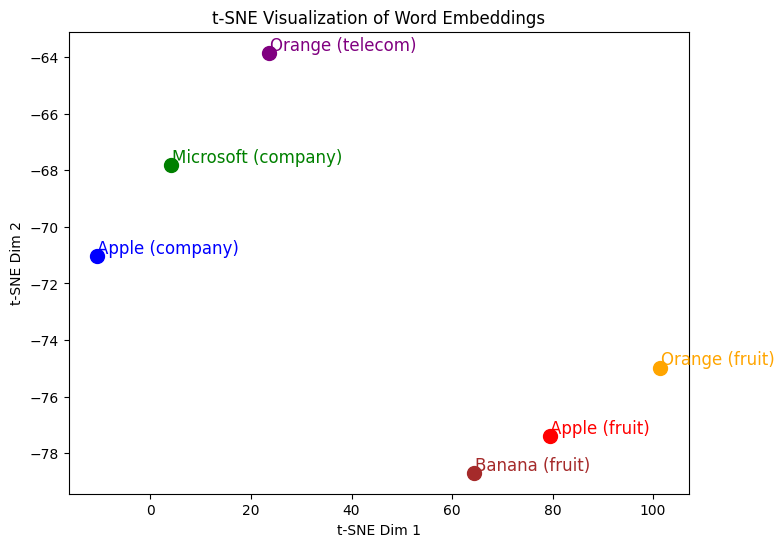

In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

######################## (Q5.2 ~ 5.3) ########################
# Sentences with different meanings of words
sentences = [
    "I ate a fresh apple.",  # Apple (fruit)
    "Apple released the new iPhone.",  # Apple (company)
    "I peeled an orange and ate it.",  # Orange (fruit)
    "The Orange network has great coverage.",  # Orange (telecom)
    "Microsoft announced a new update.",  # Microsoft (company)
    "Banana is my favorite fruit.",  # Banana (fruit)
]

# Tokenize and move to device
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)
inputs = inputs.to(device)

# Get hidden states
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

hidden_states = outputs.hidden_states[-1]  # Extract last layer embeddings

# Compute sentence-level embeddings (mean pooling)
sentence_embeddings = hidden_states.mean(dim=1).cpu().numpy()

# Words to visualize
word_labels = [
    "Apple (fruit)", "Apple (company)",
    "Orange (fruit)", "Orange (telecom)",
    "Microsoft (company)", "Banana (fruit)"
]

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(sentence_embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 6))
colors = ["red", "blue", "orange", "purple", "green", "brown"]
for i, label in enumerate(word_labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[i], s=100)
    plt.text(embeddings_2d[i, 0] + 0.1, embeddings_2d[i, 1] + 0.1, label, fontsize=12, color=colors[i])

plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Visualization of Word Embeddings")
plt.show()
##################################################

## Q6: Observe the Attention Weight

In [ ]:
#model.config.output_attentions = True

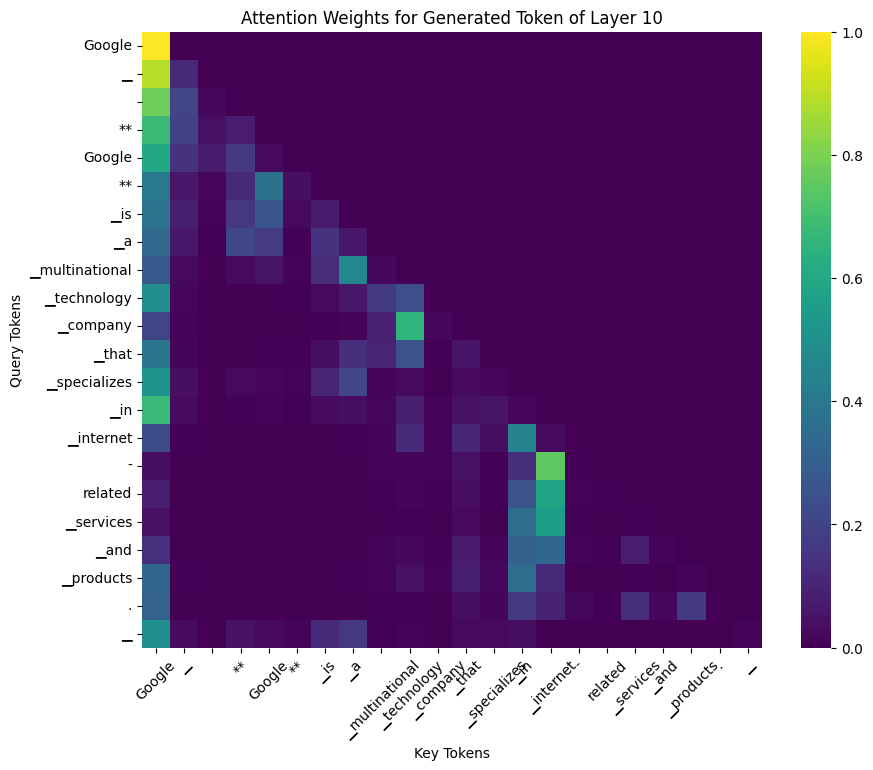

In [19]:
# Import necessary libraries
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import trange
from sklearn.decomposition import PCA

# Input prompt for text generation
prompt = "Google "
input_ids = tokenizer(prompt, return_tensors="pt")  # Tokenize the input prompt
next_token_id = input_ids.input_ids.to("cuda")  # Move input token ids to GPU
attention_mask = input_ids.attention_mask.to("cuda")  # Move attention mask to GPU
cache_position = torch.arange(attention_mask.shape[1], device="cuda")  # Position for the KV cache

# Set the number of tokens to generate and other parameters
generation_tokens = 20  # Limit for visualization (number of tokens to generate)
total_tokens = generation_tokens + next_token_id.size(1) - 1  # Total tokens to handle
layer_idx = 10  # Specify the layer index for attention visualization
head_idx = 7  # Specify the attention head index to visualize

# KV cache setup for caching key/values across time steps
from transformers.cache_utils import HybridCache
kv_cache = HybridCache(config=model.config, max_batch_size=1, max_cache_len=total_tokens, device="cuda", dtype=torch.float16)

generated_tokens = []  # List to store generated tokens
attentions = None  # Placeholder to store attention weights

num_new_tokens = 0  # Counter for the number of new tokens generated
model.eval()  # Set the model to evaluation mode

# Generate tokens and collect attention weights for visualization
for num_new_tokens in range(generation_tokens):
    with torch.no_grad():  # Disable gradients during inference for efficiency
        # Pass the input through the model to get the next token prediction and attention weights
        outputs = model(
            next_token_id,
            attention_mask=attention_mask,
            cache_position=cache_position,
            use_cache=True,  # Use the KV cache for efficiency
            past_key_values=kv_cache,  # Provide the cached key-value pairs for fast inference
            output_attentions=True  # Enable the extraction of attention weights
        )

    ######################## TODO (Q6.1 ~ 6.4) ########################
    ### You can refer to https://huggingface.co/docs/transformers/en/main_classes/output#transformers.modeling_outputs.BaseModelOutput.attentions to see the structure of model output attentions

    # Get the logits for the last generated token
    logits = outputs.logits[:, -1, :]  # shape: [batch, vocab_size]

    # Extract all attention scores
    attention_scores = outputs.attentions  # a tuple: (num_layers, batch, num_heads, seq_len, seq_len)

    ###################################################################

    # Extract attention weights for the specified layer and head
    last_layer_attention = attention_scores[layer_idx][0][head_idx].detach().cpu().numpy()

    # If it's the first generated token, initialize the attentions array
    if num_new_tokens == 0:
        attentions = last_layer_attention
    else:
        # Append the current attention weights to the existing array
        attentions = np.append(attentions, last_layer_attention, axis=0)

    # Choose the next token to generate based on the highest probability (logits)
    next_token_id = logits.argmax(dim=-1)
    generated_tokens.append(next_token_id.item())  # Add the token ID to the generated tokens list

    # Update the attention mask and next token ID for the next iteration
    attention_mask = torch.cat([attention_mask, torch.ones(1, 1, device="cuda")], dim=-1)  # Add a new attention mask for the generated token
    next_token_id = next_token_id.unsqueeze(0)  # Convert the token ID to the required shape

    # Update the KV cache with the new past key-values
    kv_cache = outputs.past_key_values
    cache_position = cache_position[-1:] + 1  # Update the cache position for the next iteration

# Decode the generated tokens into human-readable text
generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
full_text = prompt + generated_text  # Combine the prompt with the generated text

# Tokenize all the generated text (prompt + generated)
tokens = tokenizer.tokenize(full_text)

# Function to plot a heatmap of attention weights
def plot_attention(attn_matrix, tokens, title="Attention Heatmap"):
    plt.figure(figsize=(10, 8))  # Set the figure size
    sns.heatmap(attn_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis", annot=False)  # Plot the attention matrix as a heatmap
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.yticks(rotation=0)  # Rotate y-axis labels
    plt.show()

# Plot the attention heatmap for the last generated token
plot_attention(attentions, tokens, title=f"Attention Weights for Generated Token of Layer {layer_idx}")

## Q7: Observe the Activation Scores

The following code is referred from official Gemma tutorials: [Gemma Tutorial From Scratch](https://colab.research.google.com/drive/17dQFYUYnuKnP6OwQPH9v_GSYUW5aj-Rp#scrollTo=2-i7YRVLgKoT) and [SAELens](https://github.com/jbloomAus/SAELens/blob/main/tutorials/tutorial_2_0.ipynb)

In [2]:
!pip install -q sae-lens

In [2]:
from sae_lens import SAE

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-res-canonical",
    sae_id = "layer_20/width_16k/canonical",
)

print(sae, cfg_dict, sparsity)


/home/home/miniconda3/envs/Tabtranformer/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/home/miniconda3/envs/Tabtranformer/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have 

JumpReLUSAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
) {'d_in': 2304, 'd_sae': 16384, 'dtype': 'float32', 'device': 'cpu', 'apply_b_dec_to_input': False, 'normalize_activations': 'none', 'reshape_activations': 'none', 'metadata': {'sae_lens_version': '6.14.2', 'sae_lens_training_version': None, 'model_name': 'gemma-2-2b', 'hook_name': 'blocks.20.hook_resid_post', 'hook_head_index': None, 'prepend_bos': True, 'dataset_path': 'monology/pile-uncopyrighted', 'context_size': 1024, 'neuronpedia_id': 'gemma-2-2b/20-gemmascope-res-16k'}, 'architecture': 'jumprelu'} None


/tmp/ipykernel_4091/2745413651.py:3: DeprecationWarning: Unpacking SAE objects is deprecated. SAE.from_pretrained() now returns only the SAE object. Use SAE.from_pretrained_with_cfg_and_sparsity() to get the config dict and sparsity as well.
  sae, cfg_dict, sparsity = SAE.from_pretrained(


In [4]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

########################## TODO (Q7.1) ############################
html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=10004)
IFrame(html, width=1200, height=600)
###################################################################

## Q7.2~7.3: Maximum activations comparison

In [ ]:
import matplotlib.pyplot as plt

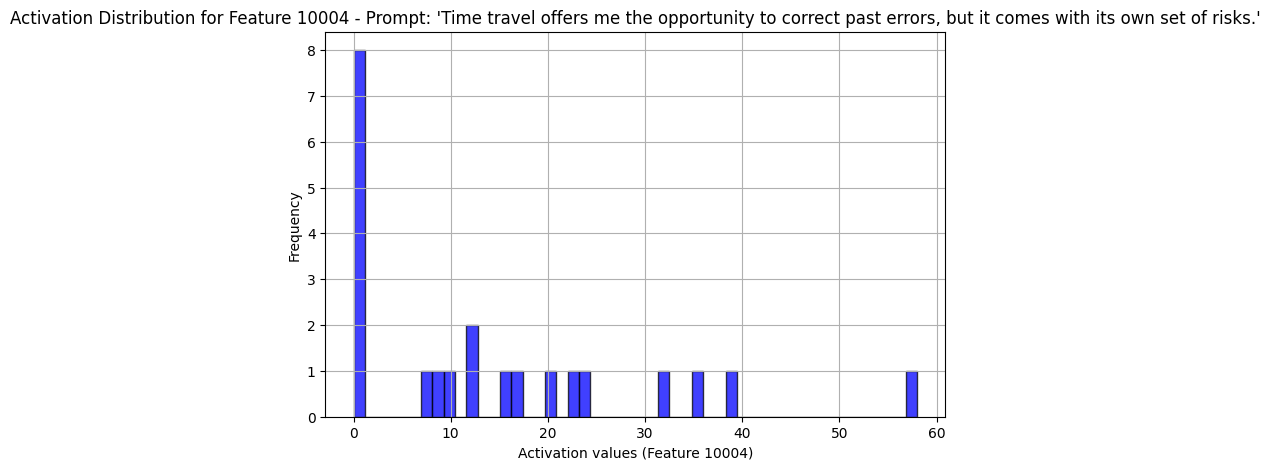

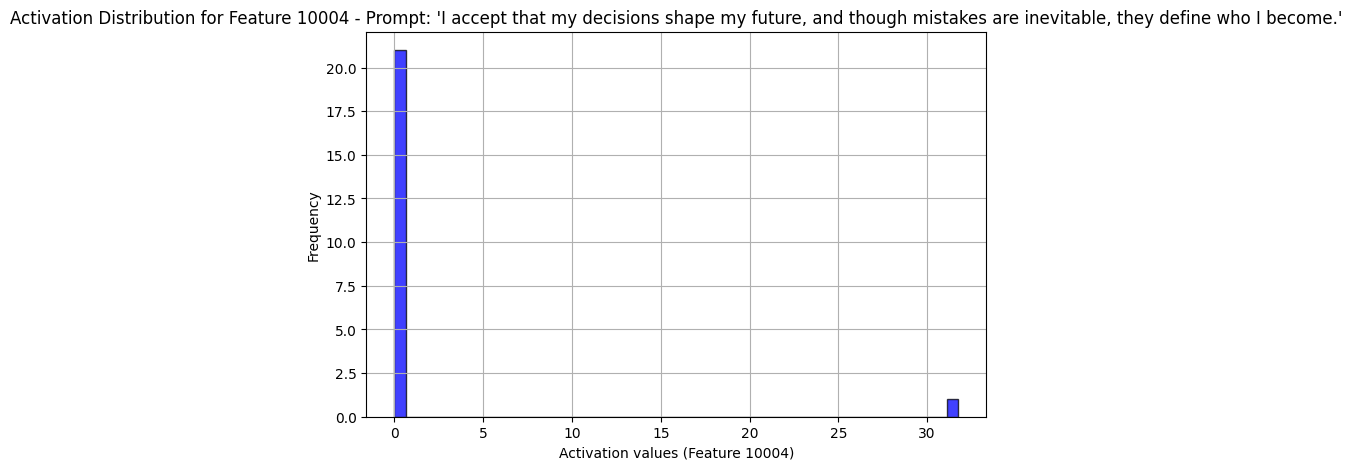

max_activation for prompt_a: 57.99748229980469
max_activation for prompt_b: 31.740509033203125


In [10]:
######################## (Q7.2 ~ 7.3) ########################

def get_max_activation(model, tokenizer, sae, prompt, feature_idx=10004):
    """
    Computes the maximum activation of a specific feature in a Sparse Autoencoder (SAE)
    for a given prompt.

    Args:
        model: The Transformer model used for generating hidden states.
        tokenizer: The tokenizer for encoding the prompt.
        sae: The Sparse Autoencoder for encoding hidden states.
        prompt (str): The input text prompt.
        feature_idx (int, optional): The index of the feature in SAE. Defaults to 10004.

    Returns:
        float: The maximum activation value for the specified feature index.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sae.to(device)

    # Tokenize the input prompt and get model outputs
    tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
    outputs = model(tokens, output_hidden_states=True)

    # Extract hidden states from the specified layer
    #hidden_states = outputs.hidden_states[sae.cfg.hook_layer]
    # 取出 Hugging Face 输出的 hidden_states tuple
    hidden_states_tuple = outputs.hidden_states

    # 解析 SAE 配置里的 hook_name 对应的层索引
    hook_name = sae.cfg.metadata.hook_name  # e.g., "blocks.20.hook_resid_post"
    layer_idx = int(hook_name.split('.')[1])  # 从 "blocks.20.hook_resid_post" 提取 20

    # 从 hidden_states tuple 里取对应层
    hidden_states = hidden_states_tuple[layer_idx]

    # Encode hidden states using SAE
    feature_acts = sae.encode(hidden_states).squeeze()  # Shape: (batch_size * seq_len, num_features)
    feature_acts = feature_acts.reshape(-1, feature_acts.shape[-1])

    # Compute max activation for the specified feature index
    max_activation = -float("inf")
    batch_max_activation = feature_acts[:, feature_idx].max().item()
    max_activation = max(max_activation, batch_max_activation)

    # Plot activation distribution
    plt.figure(figsize=(8, 5))
    plt.hist(feature_acts[:, feature_idx].cpu().detach().numpy(), bins=50, alpha=0.75, color='blue', edgecolor='black')
    plt.xlabel(f"Activation values (Feature {feature_idx})")
    plt.ylabel("Frequency")
    plt.title(f"Activation Distribution for Feature {feature_idx} - Prompt: '{prompt}'")
    plt.grid(True)
    plt.show()

    return max_activation

feature_idx = 10004
# Define the prompts
prompt_a = "Time travel offers me the opportunity to correct past errors, but it comes with its own set of risks."
prompt_b = "I accept that my decisions shape my future, and though mistakes are inevitable, they define who I become."

# Calculate the maximum activations for each prompt using the feature index
max_activation_a = get_max_activation(model, tokenizer, sae, prompt_a, feature_idx=feature_idx)
max_activation_b = get_max_activation(model, tokenizer, sae, prompt_b, feature_idx=feature_idx)

# Print the comparison
print(f"max_activation for prompt_a: {max_activation_a}")
print(f"max_activation for prompt_b: {max_activation_b}")
###########################################################

## Q7.4~7.6: Activation distribution for specific layer

feature_acts shape: torch.Size([13, 16384])


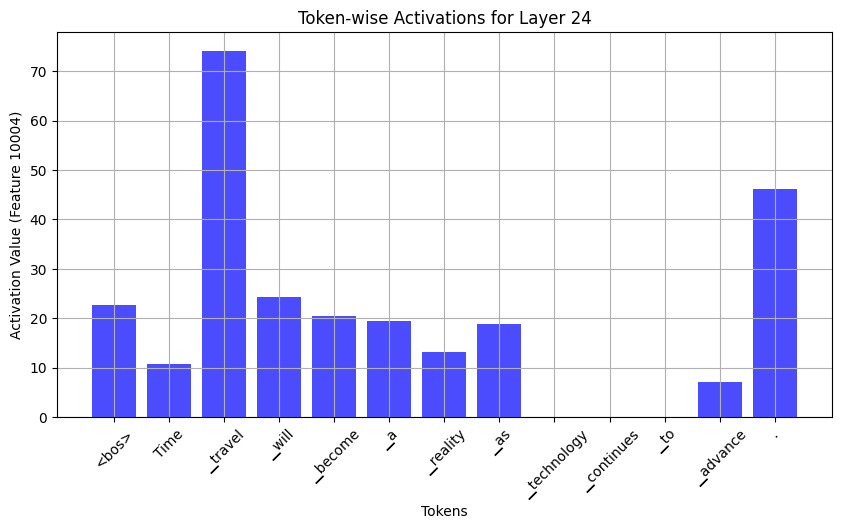

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_token_activations(model, tokenizer, sae, prompt, feature_idx=10004, layer_idx=0):
    """
    Plots activations for each token in a specific layer.

    Args:
        model: The transformer model.
        tokenizer: Tokenizer for encoding input text.
        sae: Sparse Autoencoder model.
        prompt: Input text string.
        feature_idx: Index of the feature to analyze.
        layer_idx: Layer to analyze (None uses sae.cfg.hook_layer).
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sae.to(device)

    # Tokenize input and get model output
    tokens = tokenizer(prompt, return_tensors="pt")
    token_ids = tokens["input_ids"].to(device)
    token_list = tokenizer.convert_ids_to_tokens(token_ids.squeeze().tolist())

    outputs = model(token_ids, output_hidden_states=True)

    # Choose layer
    layer_idx = layer_idx if layer_idx is not None else sae.cfg.hook_layer
    hidden_states = outputs.hidden_states[layer_idx]

    # Pass through SAE
    sae_in = hidden_states
    feature_acts = sae.encode(sae_in).squeeze()  # (batch_size, seq_len, num_features)
    print(f"feature_acts shape: {feature_acts.shape}")

    # Extract activations for the chosen feature
    activations = feature_acts[:, feature_idx].squeeze().cpu().detach().numpy()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(token_list)), activations, color='blue', alpha=0.7)
    plt.xticks(range(len(token_list)), token_list, rotation=45)
    plt.xlabel("Tokens")
    plt.ylabel(f"Activation Value (Feature {feature_idx})")
    plt.title(f"Token-wise Activations for Layer {layer_idx}")
    plt.grid(True)
    plt.show()

######################## (Q7.4 ~ 7.6) ########################
# Simply observe the figure
layer_idx = 24
prompt = "Time travel will become a reality as technology continues to advance."
plot_token_activations(model, tokenizer, sae, prompt, feature_idx, layer_idx)
###################################################################

## Q7.7~7.9: Activation distribution for specific token

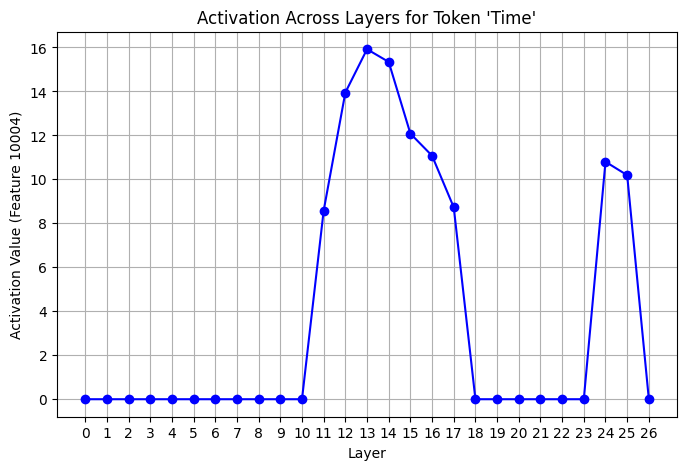

In [12]:
def plot_layer_activations(model, tokenizer, sae, prompt, token_idx=0, feature_idx=10004):
    """
    Plots activations of a specific token across all layers.

    Args:
        model: The transformer model.
        tokenizer: Tokenizer for encoding input text.
        sae: Sparse Autoencoder model.
        prompt: Input text string.
        token_idx: Index of the token to analyze.
        feature_idx: Index of the feature to analyze.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sae.to(device)

    # Tokenize input and get model output
    tokens = tokenizer(prompt, return_tensors="pt")
    token_ids = tokens["input_ids"].to(device)
    token_list = tokenizer.convert_ids_to_tokens(token_ids.squeeze().tolist())

    outputs = model(token_ids, output_hidden_states=True)

    # Collect activations across all layers
    num_layers = len(outputs.hidden_states)
    activations = []

    for layer_idx in range(num_layers):
        hidden_states = outputs.hidden_states[layer_idx]
        sae_in = hidden_states
        feature_acts = sae.encode(sae_in).squeeze()  # (batch_size, seq_len, num_features)
        # print(f"feature_acts shape: {feature_acts.shape}")
        activations.append(feature_acts[token_idx, feature_idx].item())

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(num_layers), activations, marker="o", linestyle="-", color="blue")
    plt.xlabel("Layer")
    plt.ylabel(f"Activation Value (Feature {feature_idx})")
    plt.title(f"Activation Across Layers for Token '{token_list[token_idx]}'")
    plt.xticks(range(num_layers))
    plt.grid(True)
    plt.show()

######################## (Q7.7 ~ 7.9) ########################
# Alter the token index to observe the figure
token_idx = 1
prompt = "Time travel will become a reality as technology continues to advance."
plot_layer_activations(model, tokenizer, sae, prompt, token_idx)
###################################################################